In [1]:
# ==================================================
# 0. 의존성
# ==================================================
import torch, numpy as np, torch.nn as nn
import torch.autograd as autograd
from torch.nn.utils import spectral_norm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split, ConcatDataset
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NORMAL_DIGITS, ANOMALY_DIGIT = list(range(1, 10)), 0   # 1‑9 = 정상, 0 = 이상
LATENT_DIM, IMG_SIZE       = 4, 28                   # latent↑
BATCH, EPOCHS, TH_PCT      = 16, 20, 95
LR_G, LR_D                 = 2.5e-4, 1e-5
lambda_gp, lambda_con, lambda_lat         = 0, 5, 5
ALPHA                      = 0.9                      # score 가중치


In [2]:
# ==================================================
# 1. 데이터 셋업 (train / val / test)
# ==================================================
tf = transforms.ToTensor()
mnist_train = datasets.MNIST("mnist", train=True,  download=True, transform=tf)
mnist_test  = datasets.MNIST("mnist", train=False, download=True, transform=tf)

normal_idx  = [i for i, (_, y) in enumerate(mnist_train) if y in NORMAL_DIGITS]
normal_ds   = Subset(mnist_train, normal_idx)

n_train = int(0.9 * len(normal_ds))
train_ds, val_ds = random_split(
    normal_ds, [n_train, len(normal_ds) - n_train],
    generator=torch.Generator().manual_seed(42))

anom_idx   = [i for i, (_, y) in enumerate(mnist_test) if y == ANOMALY_DIGIT]
# test = val(정상) + 0(이상)
test_ds    = ConcatDataset([val_ds, Subset(mnist_test, anom_idx)])

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)


In [3]:
# ==================================================
# 2. 네트워크 (GANomaly)
# ==================================================
def conv_block(in_c, out_c, *, k=3, s=2, p=1, bn=True, spec=False):
    conv = nn.Conv2d(in_c, out_c, k, s, p)
    if spec:
        conv = spectral_norm(conv)
    layers = [conv]
    if bn:
        layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    """Encoder-Decoder-Encoder with Skip Connections"""
    def __init__(self, zdim=LATENT_DIM):
        super().__init__()
        # E₁ : 28→14→7→4 (각 레이어를 분리하여 중간 출력을 저장)
        self.enc1_1 = conv_block(1, 32)
        self.enc1_2 = conv_block(32, 64)
        self.enc1_3 = conv_block(64, 128)
        self.enc1_flat = nn.Flatten()
        self.fc_z = nn.Linear(128 * 4 * 4, zdim)

        # D : 4→7→14→28 (Skip Connection을 위해 구조 및 파라미터 수정)
        self.fc_dec = nn.Linear(zdim, 128 * 4 * 4)

        # Decoder의 각 레이어를 분리하고, Skip Connection을 받을 수 있도록 in_channels 수정
        self.dec_1 = nn.Sequential(
            # Encoder의 (N, 64, 7, 7) 출력과 맞추기 위해 k=3, op=0 사용
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=0), nn.ReLU()
        )
        self.dec_2 = nn.Sequential(
            # Skip Connection(64) + 이전 Decoder 출력(64) = 128
            nn.ConvTranspose2d(128, 32, 4, 2, 1), nn.ReLU()
        )
        self.dec_3 = nn.Sequential(
            # Skip Connection(32) + 이전 Decoder 출력(32) = 64
            nn.ConvTranspose2d(64, 1, 4, 2, 1), nn.Tanh()
        )

        # E₂ (기존과 동일)
        self.enc2 = nn.Sequential(
            conv_block(1, 32),
            conv_block(32, 64),
            conv_block(64, 128),
            nn.Flatten())
        self.fc_z2 = nn.Linear(128 * 4 * 4, zdim)

    def forward(self, x):
        # Encoder 1: Skip Connection을 위해 중간 결과 저장
        e1_out = self.enc1_1(x)         # out: (N, 32, 14, 14)
        e2_out = self.enc1_2(e1_out)    # out: (N, 64, 7, 7)
        e3_out = self.enc1_3(e2_out)    # out: (N, 128, 4, 4)

        # Bottleneck
        z = self.fc_z(self.enc1_flat(e3_out))

        # Decoder: Skip Connection 적용
        d_in = self.fc_dec(z).view(-1, 128, 4, 4)

        # 첫 번째 Deconvolution & Skip Connection
        d1_out = self.dec_1(d_in)                             # out: (N, 64, 7, 7)
        d1_cat = torch.cat([d1_out, e2_out], 1)               # concat: (N, 128, 7, 7)

        # 두 번째 Deconvolution & Skip Connection
        d2_out = self.dec_2(d1_cat)                           # out: (N, 32, 14, 14)
        d2_cat = torch.cat([d2_out, e1_out], 1)               # concat: (N, 64, 14, 14)

        # 최종 출력 이미지 생성
        xh = self.dec_3(d2_cat)                               # out: (N, 1, 28, 28)

        # 두 번째 Encoder를 통해 재구성된 이미지에서 z2 추출
        z2 = self.fc_z2(self.enc2(xh))

        return xh, z, z2


class Discriminator(nn.Module):
    """Discriminator"""
    def __init__(self):
        super().__init__()
        # conv_block의 기본 k=3, s=2, p=1 사용
        self.net = nn.Sequential(
            conv_block(1, 64, k=4, bn=False, spec=True),   # 28->14
            conv_block(64, 128, k=4, spec=True),         # 14->7
            conv_block(128, 256, k=4, spec=True),        # 7->3
            spectral_norm(nn.Conv2d(256, 1, 3, 1, 0)) # 3->1
        )
    def forward(self, x):
        return self.net(x)


# 모델 인스턴스 생성
G, D = Generator().to(DEVICE), Discriminator().to(DEVICE)


In [4]:
# ==================================================
# 3. 학습 루프 (WGAN-GP + ℓ_con + ℓ_lat)
# ==================================================
opt_G = torch.optim.Adam(G.parameters(), LR_G, betas=(0.0, 0.9))
opt_D = torch.optim.Adam(D.parameters(), LR_D, betas=(0.0, 0.9))

def gradient_penalty(x_real, x_fake):
    a_weights = torch.rand(x_real.size(0), 1, 1, 1, device=DEVICE)
    hat = (a_weights * x_real + (1 - a_weights) * x_fake).requires_grad_(True)
    d_hat = D(hat)
    grad  = autograd.grad(d_hat.sum(), hat, create_graph=True)[0]
    gp    = (grad.flatten(1).norm(2, dim=1) - 1).pow(2).mean()
    return gp

for ep in range(1, EPOCHS + 1):
    G.train(); D.train()
    g_sum = d_sum = 0.
    n_critic = 5

    for i, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE) * 2 - 1                      # [-1,1]
        # ----- D -----
        with torch.no_grad():
            x_fake, _, _ = G(x)
        loss_D = -(D(x).mean() - D(x_fake).mean()) + lambda_gp * gradient_penalty(x, x_fake)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # ----- G -----
        if i % n_critic == 0:
            x_fake, z, z2 = G(x)

            adv = -D(x_fake).mean()

            xt, xft = (x + 1) / 2, (x_fake + 1) / 2

            con = (xt - xft).pow(2).mean()
            lat = (z - z2).pow(2).mean()

            loss_G = adv + lambda_con * con + lambda_lat * lat

            opt_G.zero_grad(); loss_G.backward(); opt_G.step()

            g_sum += loss_G.item() * x.size(0)
            d_sum += loss_D.item() * x.size(0)

    print(f"[{ep:03}/{EPOCHS}]  L_G={g_sum/len(train_ds):.4f}  L_D={d_sum/len(train_ds):.4f}")


[001/20]  L_G=-0.1437  L_D=-0.0895
[002/20]  L_G=-0.0756  L_D=-0.0196
[003/20]  L_G=-0.0643  L_D=-0.0194
[004/20]  L_G=-0.0441  L_D=-0.0204
[005/20]  L_G=-0.0387  L_D=-0.0220
[006/20]  L_G=-0.0582  L_D=-0.0244
[007/20]  L_G=-0.0625  L_D=-0.0248
[008/20]  L_G=-0.1155  L_D=-0.0272
[009/20]  L_G=-0.0903  L_D=-0.0285
[010/20]  L_G=-0.0916  L_D=-0.0286
[011/20]  L_G=-0.0741  L_D=-0.0303
[012/20]  L_G=-0.0575  L_D=-0.0315
[013/20]  L_G=-0.0550  L_D=-0.0333
[014/20]  L_G=-0.0285  L_D=-0.0347
[015/20]  L_G=-0.0222  L_D=-0.0339
[016/20]  L_G=-0.0128  L_D=-0.0355
[017/20]  L_G=-0.0186  L_D=-0.0359
[018/20]  L_G=-0.0180  L_D=-0.0364
[019/20]  L_G=0.0185  L_D=-0.0374
[020/20]  L_G=0.0310  L_D=-0.0376


In [5]:
# ==================================================
# 4. 임계치 계산 (train+val 정상 90-percentile)
# ==================================================
ALPHA   = 0.9          #  ℓ_con ↔ ℓ_lat 가중치
TH_PCT  = 90           #  퍼센타일 기준
DEVICE  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- GANomaly 스코어 함수 -----------------------------------------
def anomaly_score(x):
    """
    반환값
      score : (B,)  텐서
      x_hat : (B,C,H,W) 재구성 이미지
    공식  a_weights·ℓ_con + (1-a_weights)·ℓ_lat
    """
    x_hat, z, z_hat = G(x)                       # Generator는 3개 반환

    # [-1,1] → [0,1]로 맞춰서 픽셀 MSE 계산
    xt, xh_t = (x + 1) / 2, (x_hat + 1) / 2

    con = (xt - xh_t ).pow(2).mean([1, 2, 3])    # ℓ_con  (pixel)
    lat = (z  - z_hat).pow(2).mean(1).sqrt()     # ℓ_lat  (feature)
    return ALPHA * con + (1 - ALPHA) * lat, x_hat


# --- ① val 데이터(정상) 스코어 수집 -------------------------------
G.eval(); scores_val = []

with torch.no_grad():
    for x, _ in val_loader:
        x = x.to(DEVICE) * 2 - 1                 # [0,1] → [-1,1]
        sc, _ = anomaly_score(x)                 # sc : (B,)
        scores_val.extend(sc.cpu().numpy())

# --- ② 95-percentile 임계치 계산 ----------------------------------
scores_val = np.asarray(scores_val)
THRESH = np.percentile(scores_val, TH_PCT)
print(f"\n[Threshold] {TH_PCT}-percentile = {THRESH:.6f}")



[Threshold] 90-percentile = 0.007642


In [6]:
# ==================================================
# 5. 테스트 평가
# ==================================================
G.eval(); y_true, y_score, recon_store = [], [], []
with torch.no_grad():
    for x, y in test_loader:
        x  = x.to(DEVICE) * 2 - 1
        sc, xh = anomaly_score(x)
        y_score.extend(sc.cpu().numpy())
        y_true.extend((y == ANOMALY_DIGIT).int().numpy())
        recon_store.append((x.cpu(), xh.cpu()))

auc = roc_auc_score(y_true, y_score)
ap  = average_precision_score(y_true, y_score)
print(f"[Test]  AUROC = {auc:.4f}   AUPRC = {ap:.4f}")

[Test]  AUROC = 0.8469   AUPRC = 0.4824


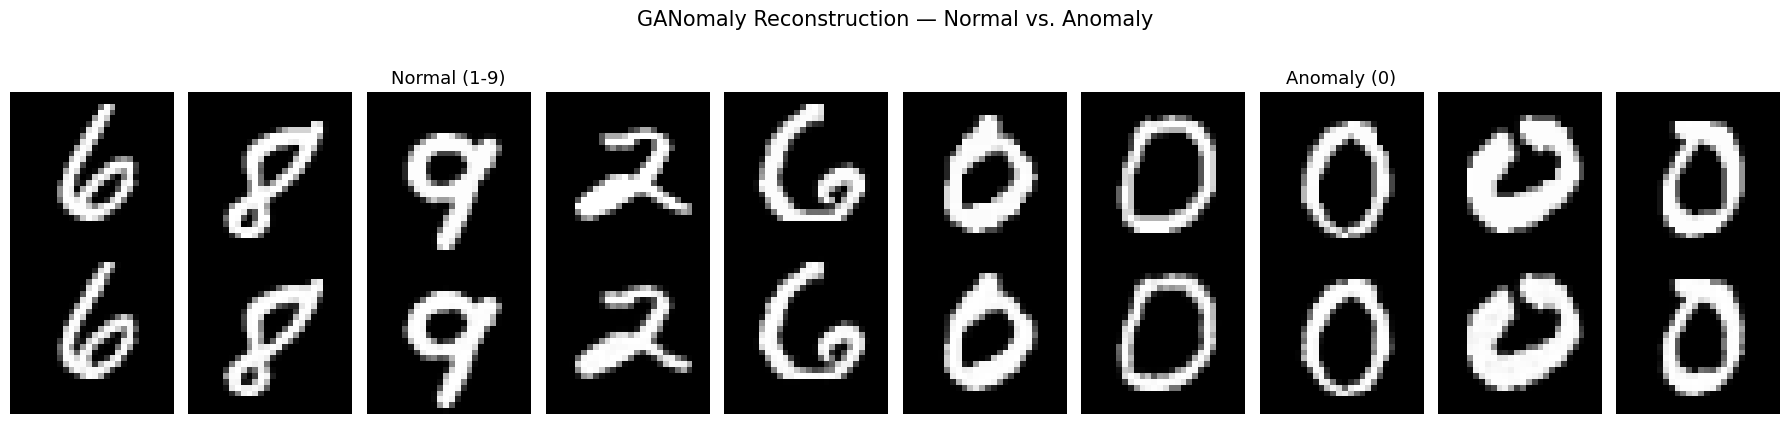

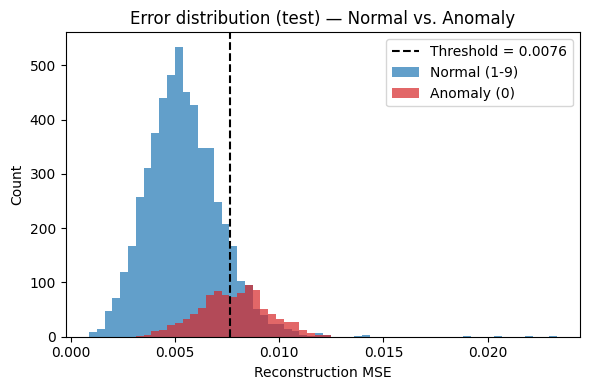

In [7]:
# ==================================================
# 6. 시각화
# ==================================================
# 6-1. 입력 ↔ 재구성 (정상 5장, 이상 5장)
norm_pairs, anom_pairs = [], []

for (x_batch, xh_batch), (_, y_batch) in zip(recon_store, test_loader):
    for img, rec, label in zip(x_batch, xh_batch, y_batch):
        label_val = label.item()
        pair = (img.add(1).div(2), rec.add(1).div(2))        # [0, 1] 복원
        if label_val == ANOMALY_DIGIT and len(anom_pairs) < 5:
            anom_pairs.append(pair)
        elif label_val != ANOMALY_DIGIT and len(norm_pairs) < 5:
            norm_pairs.append(pair)
    if len(norm_pairs) == 5 and len(anom_pairs) == 5:
        break

fig, axes = plt.subplots(2, 10, figsize=(18, 4))
for col, (inp, rec) in enumerate(norm_pairs + anom_pairs):
    axes[0, col].imshow(inp.squeeze(), cmap="gray");  axes[0, col].axis("off")
    axes[1, col].imshow(rec.squeeze(), cmap="gray");  axes[1, col].axis("off")
axes[0, 0].set_ylabel("Input", fontsize=12)
axes[1, 0].set_ylabel("Recon", fontsize=12)
axes[0, 2].set_title("Normal (1-9)", fontsize=13)
axes[0, 7].set_title("Anomaly (0)",  fontsize=13)
plt.suptitle("GANomaly Reconstruction — Normal vs. Anomaly", y=1.05, fontsize=15)
plt.tight_layout()
plt.show()

# 6-2. 오차 히스토그램 (정상·이상 색상 구분)
err_tensor   = torch.tensor(y_score)
label_tensor = torch.tensor(y_true)                # 0 = 정상, 1 = 이상

err_norm = err_tensor[label_tensor == 0]
err_anom = err_tensor[label_tensor == 1]

bins = 60
hist_norm, edges = torch.histogram(err_norm, bins=bins)
hist_anom, _     = torch.histogram(err_anom, bins=edges)     # 동일 bin 사용
centers = (edges[:-1] + edges[1:]) / 2
width   = centers[1] - centers[0]

plt.figure(figsize=(6, 4))
plt.bar(centers.numpy(), hist_norm.numpy(),
        width=width, color="#1f77b4", alpha=0.7, label="Normal (1-9)")
plt.bar(centers.numpy(), hist_anom.numpy(),
        width=width, color="#d62728", alpha=0.7, label="Anomaly (0)")
plt.axvline(THRESH, linestyle="--", color="k", label=f"Threshold = {THRESH:.4f}")

plt.xlabel("Reconstruction MSE")
plt.ylabel("Count")
plt.title("Error distribution (test) — Normal vs. Anomaly")
plt.legend()
plt.tight_layout()
plt.show()